# Predicting the Amount of a TSA Claim Reimbursement

By: Israel Fernandez, Haider Syed

## Introduction


The Transportation Security Administration is a major part of the United States Department of Homeland security, which monitors items taken onboard flights for public safety. As a result of the numerous flights taking place every day, it is natural some of these valuables get damaged or lost while on the trip to their destination. If your item is lost or damaged at a security checkpoint or during the flight, you can file a compensation claim with the TSA to see a potential reimbursement. In this notebook, we aim to predict the amount of money you will likely receive if you make a claim for your belongings being damaged or lost by the TSA.

The dataset contains information about claims that were made against the TSA for property damage, lost or damaged property. These claims are generally filed against the TSA for personal injuries, lost or damaged property during screenings. This dataset is the record of claims between 2002 - 2015 recoreded by the TSA. There are over 200,000 rows in this dataset, and each one represents a claim filed by an individual. The most 2 important columns in the dataset are Claim Amount and Close Amount. The Claim Amount is the amount of money requested by the individual with the lost or damaged property. The Close Amount is the amount of money actually received from TSA. 

In [335]:
# All import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import tree
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_regression


We took data from https://www.kaggle.com/datasets/terminal-security-agency/tsa-claims-database/data

In [336]:
df = pd.read_csv('tsa_claims.csv');

C:\Users\israe\AppData\Local\Temp\ipykernel_7052\2513889926.py:1: DtypeWarning: Columns (0,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('tsa_claims.csv');


## Initial Data Exploration

Here is the size of the dataset where all variables and missing data included.

In [337]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204267 entries, 0 to 204266
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Claim Number   204267 non-null  object
 1   Date Received  204004 non-null  object
 2   Incident Date  202084 non-null  object
 3   Airport Code   195743 non-null  object
 4   Airport Name   195743 non-null  object
 5   Airline Name   169893 non-null  object
 6   Claim Type     196354 non-null  object
 7   Claim Site     203527 non-null  object
 8   Item           200301 non-null  object
 9   Claim Amount   200224 non-null  object
 10  Status         204262 non-null  object
 11  Close Amount   135315 non-null  object
 12  Disposition    131359 non-null  object
dtypes: object(13)
memory usage: 20.3+ MB


While Claim Amount and Close Amount are the most imperative columns, other columns of interest include; Item, Status, Disposition, Claim Type, and Claim Site. All of the variables in the dataset are of type 'object', even Claim Amount and Close Amount. This could be the case because of NA values, but how could a Claim Amount be NA?

It is helpful to visualize the missing data as a whole from the dataset, as info does not display it in a coherent manner.

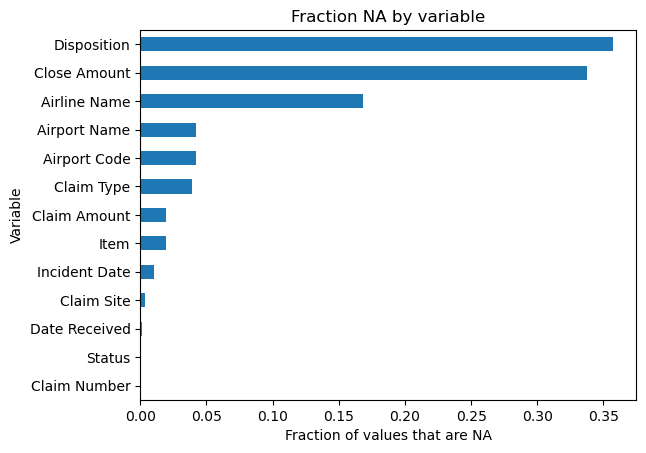

In [338]:
df.isna().mean().sort_values().plot.barh()
plt.title('Fraction NA by variable')
plt.xlabel('Fraction of values that are NA')
plt.ylabel('Variable');

The 2 largest fractions of NA data come from Close Amount and Disposition. Disposition refers to the final judgment from the TSA on your claim, and responds with either Deny, Approve in Full, or Settle. While the first 2 are straightforward, to settle means to reimburse a portion of the Claim. If you Claim for 100$ and receive 50, that would be considered a settlement. Disposition having the highest amount of NA is interesting, because Status is the variable that is directly tied to it.

Is there any correlation to Status and the amount of NA values in Disposition?

In [339]:
df['Disposition_NA'] = np.where(df['Disposition'].isna(), 1, 0)
status_na_proportion = df.groupby('Status')['Disposition_NA'].mean().sort_values(ascending=False)
print("Proportion of Disposition NA for each Status category:")
print(status_na_proportion)

Proportion of Disposition NA for each Status category:
Status
-                                                                                                                                1.000000
Approve in Full                                                                                                                  1.000000
Claim entered                                                                                                                    1.000000
Claim has been assigned for further investigation                                                                                1.000000
Closed as a contractor claim                                                                                                     1.000000
Deny                                                                                                                             1.000000
Settle                                                                                                        

We can see here that the massive amount of Na values in Disposition come from the Status categories 'In Review', 'In Litigation', and 'Insufficient'. This tells us that most of the Na data comes from claims that are still being processed, being disputed in court, or the claim was filled out incorrectly by the owner of the damaged item(s). 

Does this also correlate to Na values in Close Amount as well?

In [340]:
contingency_table = pd.crosstab(df['Disposition'].isna(), df['Close Amount'].isna())
print(contingency_table)

Close Amount   False  True 
Disposition                
False         129886   1473
True            5429  67479


It in fact does, we can see here a very strong correlation to Disposition and Close Amount when it comes to the amount of Na values in the dataframe. This makes sense as if your claim has not been completed for any reason, you would not see any money.

But how are items categorized in the dataframe?

In [341]:
df['Item'].value_counts()

Item
Other                                                                                                                                                                                                                                                                                                                                                            36908
Luggage (all types including footlockers)                                                                                                                                                                                                                                                                                                                        19128
Clothing - Shoes; belts; accessories; etc.                                                                                                                                                                                                                                           

We can see the largest category in Item by far is labeled 'Other'. This category is too vague and will hurt our understanding of how much money you will see on your claim as this item could be literally anything. There is also hundreds of singular items that are massive outliers, such as books and barber supplies that pollute the data set.

## Preprocessing Data

The data contains a lot of information that, although is good to have, is not necessary for our purposes. We are going to clean it up a bit.

First we will clean the data because our data contains objects and we need to work with floats.

In [342]:

def clean_data(col):
    cleaned_data = df[col].str.replace("$", "", regex=False).str.replace(";","").str.replace(" ", "").replace("-",np.nan)
    return cleaned_data.convert_dtypes(float)
df["Claim Amount"] = clean_data('Claim Amount')
df['Close Amount'] = clean_data('Close Amount')

This function will remove the dollar sign from the number, and replace semicolons from the numbers. The TSA dataset uses semicolons as we use commas, to seperate when a value is 1,000 or more. In this case it shows as 1;000. We also will convert any potential negative numbers to Na to prevent any issues with the data. It is not possible to claim or close out to a negative value but it is possible to incorrectly enter it.

We want to drop any NA values in the columns that we care about most, and remove columns with data like 'Other' to gain more precise predictions.

In [343]:
df = df.dropna(subset = ['Close Amount'])
df = df.dropna(subset = ['Claim Amount'])
df = df.dropna(subset = ['Disposition'])
df = df.dropna(subset = ['Item'])
df = df[df['Item'] != 'Other']

item_counts = df['Item'].value_counts()
items_to_keep = item_counts.head(15).index
df = df[df['Item'].isin(items_to_keep)]
df = df[df['Item'] != 'Other']

We dropped the Na values in Claim Amount and Close Amount because they will pollute our predictions, as well as the Na values in Disposition. Items labeled Na are just as useless to us. Claims being processed or disputed cannot behoove our predictions either, we only want to look at claims that have finished their processing. Given the previous crosstab most of the columns with Na values for Disposition also will be eliminated when we drop the Na values for close Amount but having any amount of Na values for these specific columns will do us no good.

Our 2 most important columns are still object types however, so we need to convert them to to numbers in order to use them for calculations.

In [344]:
df['Claim Amount'] = pd.to_numeric(df['Claim Amount'], errors='coerce')
df['Close Amount'] = pd.to_numeric(df['Close Amount'], errors='coerce')

We also have an issue with columns having tons of categories with little to no representation, which harms our predictions further

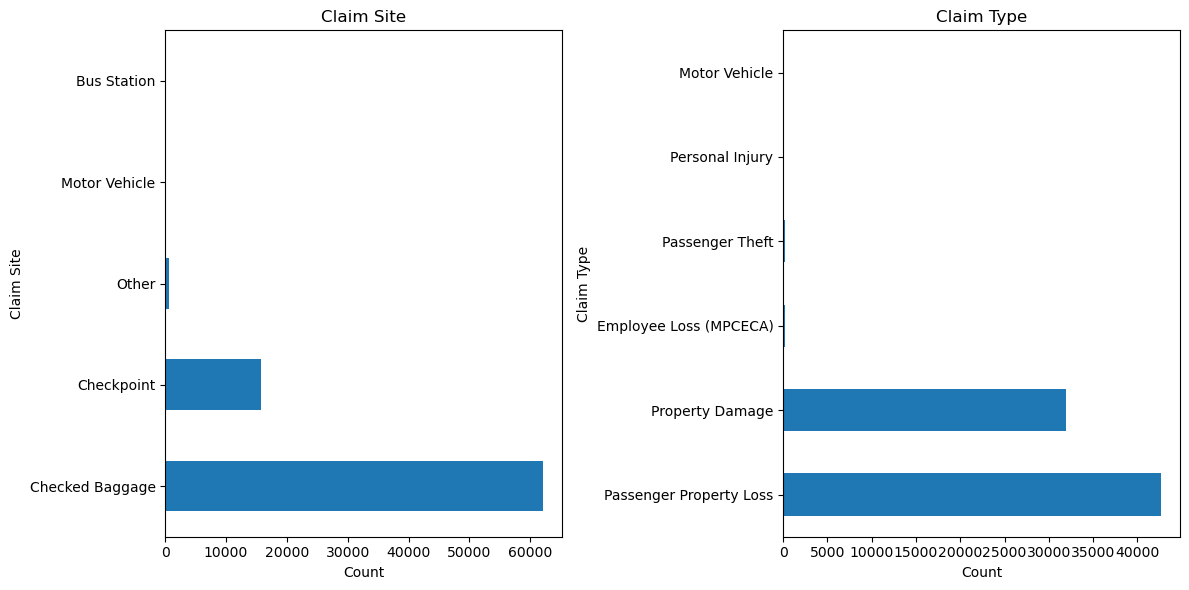

In [345]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

df['Claim Site'].value_counts().plot.barh(ax=axes[0], title='Claim Site')
df['Claim Type'].value_counts().plot.barh(ax=axes[1], title='Claim Type')
axes[0].set_xlabel('Count')
axes[1].set_xlabel('Count')
plt.tight_layout();

For the Claim Site, we can see the only places where items are damaged or lost are at checkpoints or when they are checked in and being loaded into flights. Claim Type has a similar issue where property damage and property loss make up the vast majority. We will be removing the other categories.

In [346]:
top_2_claim_site = df['Claim Site'].value_counts().head(2).index
df = df[df['Claim Site'].isin(top_2_claim_site)]
top_2_claim_amount = df['Claim Amount'].value_counts().head(2).index
df = df[df['Claim Amount'].isin(top_2_claim_amount)]

This will keep only the 2 most popular categories in Claim Type and Claim Site, and will allow us to predict with less test error..

For the claim amount, we want to eliminate the top 0.5% quantile so that we remove the outliers of people asking for exhorbatant amounts. This information is not useful to us. 

In [347]:
top_05_percent_cutoff = df['Claim Amount'].quantile(0.995)
df = df[df['Claim Amount'] <= top_05_percent_cutoff]

We also will want to change some names in categories in order to make it easier to read and graph.

In [348]:
df['Item'] = df['Item'].replace({
    'Luggage (all types including footlockers)': 'Luggage',
    'Clothing - Shoes; belts; accessories; etc.': 'Clothing',
    'Jewelry - Fine': 'Jewelry',    
    'Cameras - Digital': 'Cameras',
    'Computer - Laptop': 'Computer',
    'Eyeglasses - (including contact lenses)': 'Eyeglasses',
    'Cosmetics - Perfume; toilet articles; medicines; soaps; etc.': 'Cosmetics',
    'Sporting Equipment & Supplies (footballs; parachutes; etc.)': 'Sporting Equipment',
    'MP3 Players-(iPods; etc)': 'MP3 Players',
    'DVD/CD Players': 'DVD/CD Players',
    'Cell Phones': 'Cell Phones',
    'Currency': 'Currency',
    'Medicines': 'Medicines',
    'Locks': 'Locks'
})

While we will not be removing all of the items from the dataset that are not the most popular, we will only be using these for plots in order for our visualizations to be readible. 

## Data Visualization

The focus of this paper is the Items portion of the dataset. To better understand the data we have, we are going to plot the distributions for which claims are made.

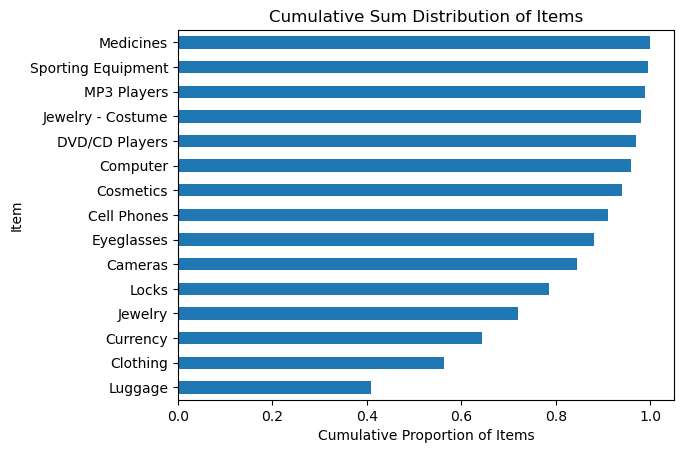

In [349]:
df['Item'].value_counts(normalize = True).cumsum().head(15).plot.barh()
plt.ylabel('Item')
plt.xlabel('Cumulative Proportion of Items')
plt.title('Cumulative Sum Distribution of Items');

The plot shows where the majority of our data lies. Luggage and clothing look to be the most popular items to be lost/damage. It also seems like the majority of items are DVD/CD Players and below. We need to narrow our scope a lot more because we want to be able to display meaningful plots. Lets take a look at what happens if we attempt to view our data as it is even after preprocessing.

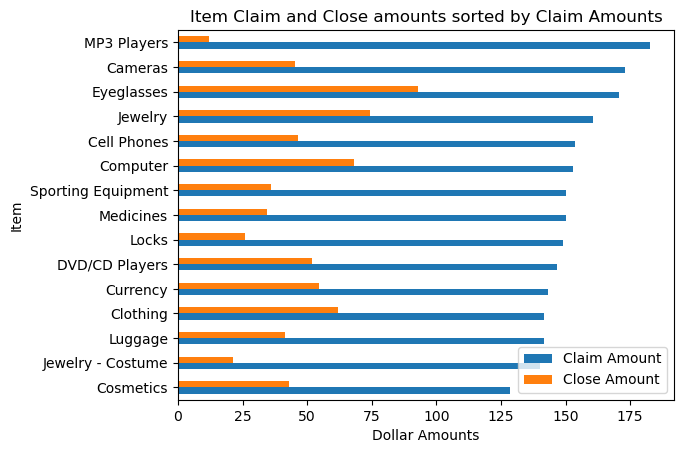

In [350]:
df.groupby("Item")[['Claim Amount', 'Close Amount']].mean().sort_values(by="Claim Amount").plot.barh()
plt.xlabel('Dollar Amounts')
plt.title('Item Claim and Close amounts sorted by Claim Amounts');

While denied gives you no money back and approval will give you all of your money back, a settlement can be for any amount of money in between. How much money will you see in your average settlement. We will be dividing Close Amount by Claim Amount to make sure we see the exact ratio.

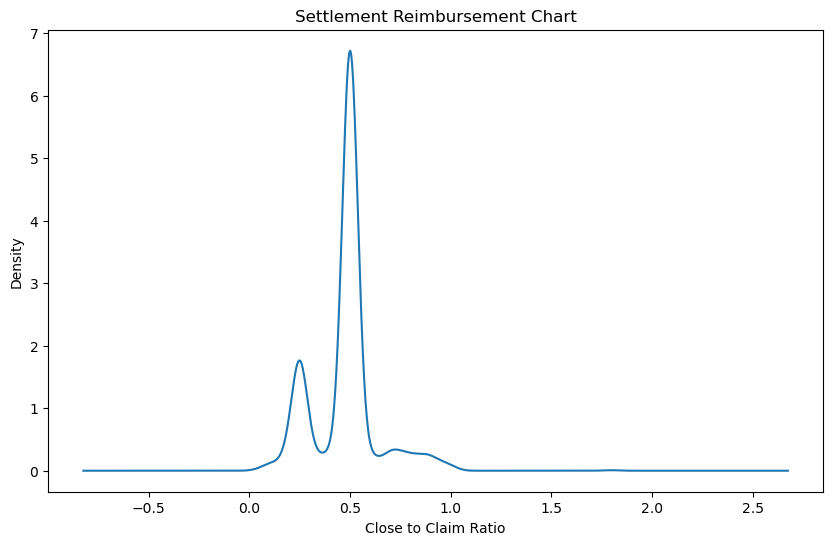

In [351]:
df['CloseToClaimRatio'] =  (df['Close Amount'] / df['Claim Amount'])
settle_df = df[df['Disposition'] == 'Settle']
plt.figure(figsize=(10, 6))
plt.title("Settlement Reimbursement Chart")
plt.xlabel("Close to Claim Ratio")
settle_df['CloseToClaimRatio'].plot.density();

We can see that the most common amount returned in a settlement is about half of what you claim for, and the only other popular choice being about a quarter of what you can expect back from a claim. 

However, the actual expected amount can change dramatically when you are observing all 3 disposition options. What is the distribution for the most popular items to be claimed for?

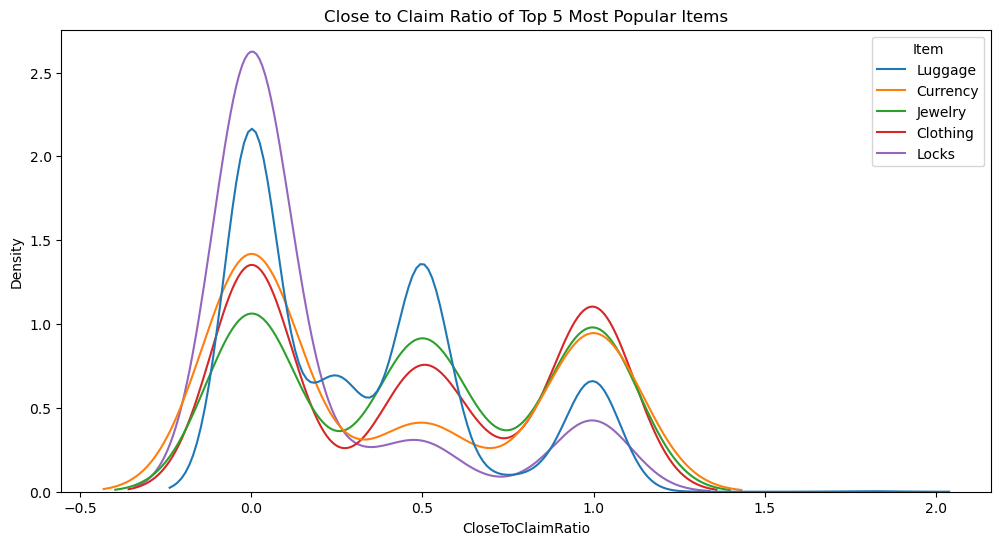

In [352]:
top_5_items = df['Item'].value_counts().head(5).index
top_5_df = df[df['Item'].isin(top_5_items)]
plt.figure(figsize=(12, 6))
plt.title("Close to Claim Ratio of Top 5 Most Popular Items")
sns.kdeplot(data=top_5_df, x='CloseToClaimRatio', hue='Item', common_norm=False);

We can now observe which items are most likely to be denied, settled, and approved in full. Locks for luggage and other possesions seem to be denied the most frequently, and jewelry is least likely. Given the dramatic price difference between the 2 items this is a reasonable choice by the TSA. The most commonly settled item is luggage, which makes sense as luggage is containing other objects, so TSA does not know the direct value of the items contained inside. It could be cheap clothes or expensive antiques. The highest fully reimbursed items are clothes as their value can be tracked with more concrete data then other items while also not being incredibly expensive. Most average people are wearing average clothes, especially at an airport so it is an inexpensive claim to approve. Locks have the lowest settled and approval rate which matches alongside their high denied rate.

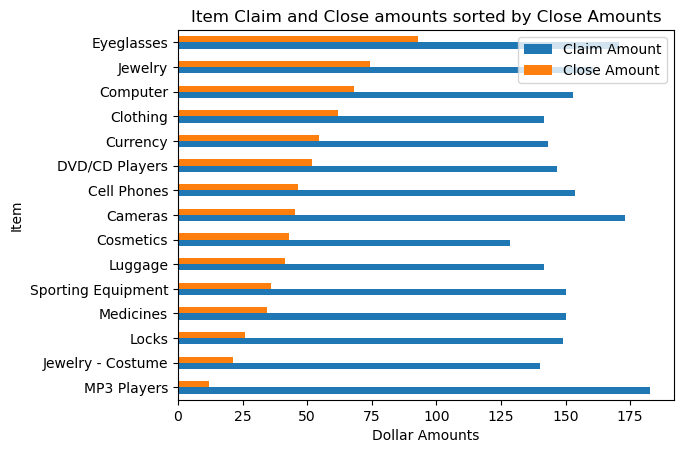

In [353]:
df.groupby("Item")[['Claim Amount', 'Close Amount']].mean().sort_values(by="Close Amount").head(15).plot.barh()
plt.xlabel('Dollar Amounts')
plt.title('Item Claim and Close amounts sorted by Close Amounts');

Now our data is significantly more readable. We have resorted our data so that we sort by Close Amount because that is what we want to start focusing on. From here we want to focus on percentage of Close Amount based on Claim Amount. That is to say, we want to know how much money would be reimbursed based on how much money was requested.

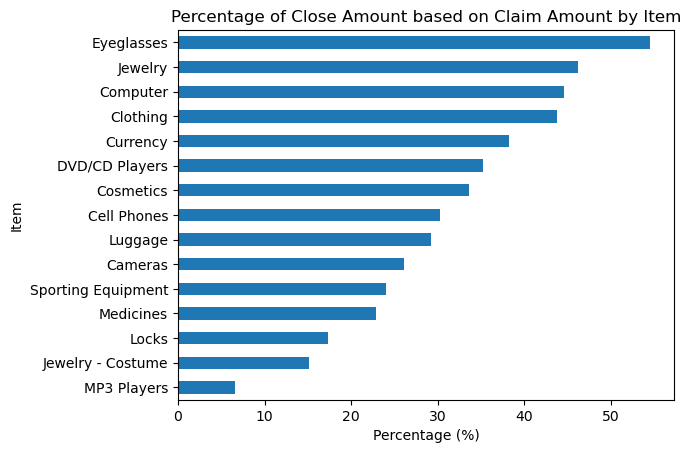

In [354]:
grouped = df.groupby("Item")[["Claim Amount", "Close Amount"]].mean()
grouped["Percentage"] = (grouped["Close Amount"] / grouped["Claim Amount"]) * 100
grouped = grouped.sort_values(by="Percentage")
grouped["Percentage"].tail(15).plot.barh()
plt.xlabel('Percentage (%)')
plt.title('Percentage of Close Amount based on Claim Amount by Item');

Now we are getting somewhere. From the graph, it looks like if you were to request a reimbursement based on a lost/damanged Cell Phone you are likely to get about 25% reimbursement of the value of the item. It also looks like Currency is the least amount reimbursed due to loss/damage. It makes sense because it is much more difficult to prove that that item was actually lost. 

## Machine Learning

We will now start to train on the dataset to give a predictive output. Circling back to the objective, we want to predict the percentage back you might get if you were to file a claim on a given item type. To start, we will do a little preprocessing to encode our categorical Item data for a regression algorithm.

In [355]:
df = pd.get_dummies(df, columns=['Item', 'Disposition', 'Status', 'Claim Type'], drop_first=True)

# Assign Predictor and Target variables
predictors = ['Claim Amount'] + list(df.filter(like='Item_').columns) + \
             list(df.filter(like='Disposition_').columns) + \
             list(df.filter(like='Status_').columns) + \
             list(df.filter(like='Claim Type_').columns)
target = 'Close Amount'

Now that we have our encoded dataframe and our target, we need to then split our data into training and test data.

In [356]:
X = df[predictors].values
y = df[target].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

Great! Now that we have split our dataset into 30% test data and 70% training data, we can move on to scaling our data to get better results for machine learning.

In [357]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

We have successfully scaled our data. Now we need to actually train our data using linear regression.

In [358]:
regr = LinearRegression()
regr.fit(X_train, y_train)

LinearRegression()

Here is our baseline for Linear Regression

In [359]:
mean_target = y_train.mean()
mse_baseline = ((mean_target - y_train)**2).mean()
rmse_baseline = np.sqrt(mse_baseline)
print(f"Baseline RMSE: {rmse_baseline:.1f}".format())

Baseline RMSE: 59.1


Here is our feature selection and cross evaluation to improve RMSE.

In [360]:
selector = SelectKBest(mutual_info_regression, k='all')
X_selected = selector.fit_transform(X, y)
cv_scores = cross_val_score(regr, X_selected, y, cv=10, scoring='neg_mean_squared_error')
cv_scores = cross_val_score(regr, X, y, scoring='neg_mean_absolute_error', cv=10)
mean_cv_mae = -cv_scores.mean()
print(f"Mean Cross-Validation MAE: {mean_cv_mae:.3g}")

Mean Cross-Validation MAE: 20.5


Now it is time to see how well we did.

In [361]:
y_pred = regr.predict(X_test)
test_rmse = np.sqrt(((y_pred - y_test)**2).mean())
print('test RMSE: {:.3g}'.format(test_rmse))

test RMSE: 28.4


Now that we are getting good results with linear regression, we will see about a tree regression model.

In [362]:
# Train decision tree regressor
regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

With the regressor loaded, we can now perform a grid search cross validation to find the best hyperparameters for our decision tree regressor.

In [363]:
param_grid = {
    'max_depth': range(2, 10),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(2, 10),
    'max_features': ['sqrt', 'log2']
}


grid_search = GridSearchCV(
    estimator=regressor,
    param_grid=param_grid,
    cv=10,
    scoring='neg_mean_squared_error',
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': range(2, 10),
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': range(2, 10),
                         'min_samples_split': range(2, 10)},
             scoring='neg_mean_squared_error')

Once that is done, we will take a look at the results.

In [364]:
y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("DecisionTreeRegressor")
print(f"Test Root Mean Squared Error: {rmse:.1f}")

baseline_pred = np.full_like(y_test, y_train.mean())  # Mean prediction baseline
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
print(f"Baseline RMSE: {baseline_rmse:.1f}")

DecisionTreeRegressor
Test Root Mean Squared Error: 21.9
Baseline RMSE: 59.3


## Conclusion

The characteristics studied above demonstrate to what degree which items are generally safer to travel with, and how much you may see on your return if the item is lost or damaged. While luggage is the most common item carried by passengers, and as a result the most popularly lost item by TSA, it is eyeglasses that contained the highest refund rate out of any items carried. This can be due to glasses being significantly easier to prove damage to, as they are typically always carried directly by passengers. However, the distribution shows that you are only likely to see about half of that value due to denials and settlements. Out of the most popular items brought on flights, you have a low chance of receiving any amount of compensation if your locks are lost or damaged during a flight, but it is highly unlikely your claim for jewelry will be denied. We can also see that the DecisionTreeClassifier had a lower RMSE then LinearRegression for predicting what you will receive from your claim.

The difference between damaged and lost items also provides an intriguing point of reference to continue the study. If your item is completely lost, how can TSA verify you were every carrying it besides it being checked in? The disparity between lost and damaged items can serve a solid foundation for a future study, which can assist passengers taking their valuables through TSA.